# Data preprocessing steps
Same as in LSTM approach

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

def expand_monthly(file, sheet_name=None):
    # Read the file
    df = pd.read_excel(file, sheet_name=sheet_name) if file.endswith('.xlsx') else pd.read_csv(file)
    
    # Convert observation_date to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    
    # Create a list to store daily data
    daily_rows = []
    
    # Iterate through each row
    for _, row in df.iterrows():
        # Get the number of days in the month
        days_in_month = row['observation_date'].days_in_month
        
        # Create daily rows for this month
        for day in range(1, days_in_month + 1):
            daily_row = row.copy()
            daily_row['observation_date'] = row['observation_date'].replace(day=day)
            daily_rows.append(daily_row)
    
    # Convert to DataFrame
    daily_df = pd.DataFrame(daily_rows)
    
    # Sort and reset index
    daily_df = daily_df.sort_values('observation_date').reset_index(drop=True)
    
    return daily_df

# Process files
liquidity = expand_monthly('m1m2.xlsx', 'Monthly')
fedIR = expand_monthly('fedIR.csv')






# Read USD strength data
usd_strength = pd.read_csv('usdstrength.csv')
usd_strength['Date'] = pd.to_datetime(usd_strength['Date'])

# Create a continuous date range
start_date = usd_strength['Date'].min()
end_date = usd_strength['Date'].max()
continuous_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new dataframe with continuous dates
continuous_df = pd.DataFrame({'Date': continuous_dates})

# Merge with original data
usd_strength_continuous = continuous_df.merge(usd_strength, on='Date', how='left')

# Fill missing values
for col in ['Open', 'High', 'Low', 'Close']:
    # First, interpolate linearly
    usd_strength_continuous[col] = usd_strength_continuous[col].interpolate()

# If there are still NaNs at the start or end, use forward or backward fill
for col in ['Open', 'High', 'Low', 'Close']:
    usd_strength_continuous[col] = usd_strength_continuous[col].fillna(method='ffill').fillna(method='bfill')


C:\Users\zhang\AppData\Local\Temp\ipykernel_28168\3990247445.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  usd_strength['Date'] = pd.to_datetime(usd_strength['Date'])
C:\Users\zhang\AppData\Local\Temp\ipykernel_28168\3990247445.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usd_strength_continuous[col] = usd_strength_continuous[col].fillna(method='ffill').fillna(method='bfill')


In [2]:
# TRUNCATING DATASETS from 2015-03-02 to 2025-02-28
usd_strength_continuous = usd_strength_continuous[['Date', 'Close']]
dollar_index_selected = usd_strength_continuous[usd_strength_continuous['Date'].between('2015-03-02', '2025-01-31')]

liquidity_selected = liquidity[liquidity['observation_date'].between('2015-03-02', '2025-01-31')]

fedIR_selected = fedIR[fedIR['observation_date'].between('2015-03-02', '2025-01-31')]

print(dollar_index_selected.head())
print(liquidity_selected.head())
print(fedIR_selected.head())

print(dollar_index_selected.tail())
print(liquidity_selected.tail())
print(fedIR_selected.tail())

         Date  Close
91 2015-03-02  95.47
92 2015-03-03  95.37
93 2015-03-04  95.91
94 2015-03-05  96.35
95 2015-03-06  97.72
      observation_date  M1SL_M2SL
20514       2015-03-02    0.25198
20515       2015-03-03    0.25198
20516       2015-03-04    0.25198
20517       2015-03-05    0.25198
20518       2015-03-06    0.25198
      observation_date  FEDFUNDS
22159       2015-03-02      0.11
22160       2015-03-03      0.11
22161       2015-03-04      0.11
22162       2015-03-05      0.11
22163       2015-03-06      0.11
           Date   Close
3710 2025-01-27  107.34
3711 2025-01-28  107.87
3712 2025-01-29  108.00
3713 2025-01-30  107.80
3714 2025-01-31  108.37
      observation_date  M1SL_M2SL
24133       2025-01-27    0.85597
24134       2025-01-28    0.85597
24135       2025-01-29    0.85597
24136       2025-01-30    0.85597
24137       2025-01-31    0.85597
      observation_date  FEDFUNDS
25778       2025-01-27      4.33
25779       2025-01-28      4.33
25780       2025-01-29   

In [3]:
# MERGE the three datasets - US DOLLAR INDEX, FED IR, MONEY SUPPLY

intermediateMerge_df = dollar_index_selected.merge(
    liquidity_selected, 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
).merge(
    fedIR_selected, 
    left_on='Date', 
    right_on='observation_date', 
    how='inner'
)

intermediateMerge_df = intermediateMerge_df[["Date", "Close", "M1SL_M2SL", "FEDFUNDS"]]
intermediateMerge_df['dxyclose'] = intermediateMerge_df['Close']
intermediateMerge_df = intermediateMerge_df.drop('Close',axis=1)
print(intermediateMerge_df)

           Date  M1SL_M2SL  FEDFUNDS  dxyclose
0    2015-03-02    0.25198      0.11     95.47
1    2015-03-03    0.25198      0.11     95.37
2    2015-03-04    0.25198      0.11     95.91
3    2015-03-05    0.25198      0.11     96.35
4    2015-03-06    0.25198      0.11     97.72
...         ...        ...       ...       ...
3619 2025-01-27    0.85597      4.33    107.34
3620 2025-01-28    0.85597      4.33    107.87
3621 2025-01-29    0.85597      4.33    108.00
3622 2025-01-30    0.85597      4.33    107.80
3623 2025-01-31    0.85597      4.33    108.37

[3624 rows x 4 columns]


In [4]:
# IMPORT API Datasets

SPY = yf.Ticker("^GSPC").history(period="10y")
SPY = SPY.reset_index()
SPY_selected = SPY[SPY['Date'].between('2015-03-02', '2025-01-31')]
SPY_selected.loc[:, 'Date'] = SPY_selected['Date'].dt.date

SPY_selected

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-03-02,2105.229980,2117.520020,2104.500000,2117.389893,3409490000,0.0,0.0
1,2015-03-03,2115.760010,2115.760010,2098.260010,2107.780029,3262300000,0.0,0.0
2,2015-03-04,2107.719971,2107.719971,2094.489990,2098.530029,3421110000,0.0,0.0
3,2015-03-05,2098.540039,2104.250000,2095.219971,2101.040039,3103030000,0.0,0.0
4,2015-03-06,2100.909912,2100.909912,2067.270020,2071.260010,3853570000,0.0,0.0
...,...,...,...,...,...,...,...,...
2492,2025-01-27,5969.040039,6017.169922,5962.919922,6012.279785,5198750000,0.0,0.0
2493,2025-01-28,6026.970215,6074.540039,5994.629883,6067.700195,4473640000,0.0,0.0
2494,2025-01-29,6057.700195,6062.830078,6012.959961,6039.310059,4115310000,0.0,0.0
2495,2025-01-30,6050.750000,6086.640137,6027.459961,6071.169922,4634620000,0.0,0.0


In [5]:
# CALCULATE TECHNICAL INDICATORS

import pandas as pd
import numpy as np

def calculate_technical_indicators(df):
    """
    Calculate multiple technical indicators for a given OHLCV DataFrame
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: Open, High, Low, Close, Volume
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with additional technical indicator columns
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    indicators_df = df.copy()
    
    # Simple Moving Averages
    indicators_df['MA5'] = indicators_df['Close'].rolling(window=5).mean()
    indicators_df['MA10'] = indicators_df['Close'].rolling(window=10).mean()
    
    # Relative Strength Index (RSI)
    def calculate_rsi(data, periods=14):
        delta = data.diff()
        
        # Make two series: one for lower closes and one for higher closes
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        
        # Calculate the EWMA
        roll_up = up.ewm(com=periods-1, adjust=False).mean()
        roll_down = down.ewm(com=periods-1, adjust=False).mean()
        
        # Calculate the RSI based on EWMA
        rs = roll_up / roll_down
        rsi = 100.0 - (100.0 / (1.0 + rs))
        
        return rsi
    
    indicators_df['RSI'] = calculate_rsi(indicators_df['Close'])
    
    # MACD (Moving Average Convergence Divergence)
    def calculate_macd(data, slow=26, fast=12, signal=9):
        # Calculate the Fast and Slow Exponential Moving Averages
        exp1 = data.ewm(span=fast, adjust=False).mean()
        exp2 = data.ewm(span=slow, adjust=False).mean()
        
        # Calculate the MACD
        macd = exp1 - exp2
        
        # Calculate the signal line
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        
        return macd, signal_line
    
    indicators_df['MACD'], indicators_df['MACD_Signal'] = calculate_macd(indicators_df['Close'])
    
    # Bollinger Bands
    def calculate_bollinger_bands(data, window=20, num_std=2):
        # Calculate the moving average
        rolling_mean = data.rolling(window=window).mean()
        
        # Calculate the standard deviation
        rolling_std = data.rolling(window=window).std()
        
        # Calculate upper and lower bands
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        
        return rolling_mean, upper_band, lower_band
    
    indicators_df['BOLL_MA'], indicators_df['BOLL_Upper'], indicators_df['BOLL_Lower'] = calculate_bollinger_bands(indicators_df['Close'])
    
    # Rate of Change (ROC)
    def calculate_roc(data, periods=10):
        return (data / data.shift(periods) - 1) * 100
    
    indicators_df['ROC'] = calculate_roc(indicators_df['Close'])
    
    # Momentum (MTM)
    def calculate_momentum(data, periods=1):
        return data - data.shift(periods)
    
    indicators_df['MTM1'] = calculate_momentum(indicators_df['Close'], periods=1)
    indicators_df['MTM3'] = calculate_momentum(indicators_df['Close'], periods=3)
    
    return indicators_df

# Example usage (commented out)
SPY_indicators = calculate_technical_indicators(SPY_selected)
print(SPY_indicators)

            Date         Open         High          Low        Close  \
0     2015-03-02  2105.229980  2117.520020  2104.500000  2117.389893   
1     2015-03-03  2115.760010  2115.760010  2098.260010  2107.780029   
2     2015-03-04  2107.719971  2107.719971  2094.489990  2098.530029   
3     2015-03-05  2098.540039  2104.250000  2095.219971  2101.040039   
4     2015-03-06  2100.909912  2100.909912  2067.270020  2071.260010   
...          ...          ...          ...          ...          ...   
2492  2025-01-27  5969.040039  6017.169922  5962.919922  6012.279785   
2493  2025-01-28  6026.970215  6074.540039  5994.629883  6067.700195   
2494  2025-01-29  6057.700195  6062.830078  6012.959961  6039.310059   
2495  2025-01-30  6050.750000  6086.640137  6027.459961  6071.169922   
2496  2025-01-31  6096.790039  6120.910156  6030.930176  6040.529785   

          Volume  Dividends  Stock Splits          MA5         MA10  \
0     3409490000        0.0           0.0          NaN          

In [6]:
# IMPORT VIX data FROM YFINANCE

VIX = yf.Ticker("^VIX").history(period = "10y")
VIX = VIX.reset_index()
VIX_selected = VIX[VIX['Date'].between('2015-03-02', '2025-01-31')]
VIX_selected = VIX_selected[['Date','Close']]
VIX_selected['VIXClose'] = VIX_selected['Close']
VIX_selected = VIX_selected.drop("Close", axis = 1)

In [7]:
# Do the same for other dataframes
intermediateMerge_df = intermediateMerge_df.copy()
intermediateMerge_df['Date'] = pd.to_datetime(intermediateMerge_df['Date']).dt.tz_localize(None)

VIX_selected = VIX_selected.copy()
VIX_selected['Date'] = pd.to_datetime(VIX_selected['Date']).dt.tz_localize(None)

SPY_indicators = SPY_indicators.copy()
SPY_indicators['Date'] = pd.to_datetime(SPY_indicators['Date']).dt.tz_localize(None)

# Now merge
final_messy_df = SPY_indicators.merge(
    intermediateMerge_df, 
    on='Date', 
    how='left'
).merge(
    VIX_selected, 
    on='Date', 
    how='left'
)

final_messy_df.columns
final_NA_df = final_messy_df.drop(["Open", "High", "Low", "Dividends", "Stock Splits"], axis = 1)
final_df = final_NA_df.dropna()
print(final_df.columns)
final_df.to_csv("final_df.csv")

Index(['Date', 'Close', 'Volume', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_Signal',
       'BOLL_MA', 'BOLL_Upper', 'BOLL_Lower', 'ROC', 'MTM1', 'MTM3',
       'M1SL_M2SL', 'FEDFUNDS', 'dxyclose', 'VIXClose'],
      dtype='object')


# Training the DQN model
In this cell we train the actual DQN model. 

A brief outline on how this works: Several "agents" are put into a simulated market environment and rewarded/penalised according to the success of their buy/sell decisions. Agents eventually learn what a good policy (AKA a good trading style) via this reward mechanism.

The performance of several agents can be seen below.

To train more agents (and witness a greater diversity in trading styles!), simply modify the num_agents parameter. 

Training Agent 1...


C:\Users\zhang\AppData\Local\Temp\ipykernel_28168\290599154.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([i[0] for i in minibatch])


Agent 1 Metrics: {'Total Return (%)': 159.302001953125, 'Sharpe Ratio': 0.6985242061222764, 'Max Drawdown (%)': 65.2675551792261, 'Final Portfolio Value': 25930.2001953125}
Training Agent 2...
Agent 2 Metrics: {'Total Return (%)': 161.1355859375, 'Sharpe Ratio': 0.702473774430164, 'Max Drawdown (%)': 65.50966868099687, 'Final Portfolio Value': 26113.55859375}
Training Agent 3...
Agent 3 Metrics: {'Total Return (%)': 90.37028442382812, 'Sharpe Ratio': 0.7740675685479583, 'Max Drawdown (%)': 50.33120643874016, 'Final Portfolio Value': 19037.028442382812}
Training Agent 4...
Agent 4 Metrics: {'Total Return (%)': 1.98170654296875, 'Sharpe Ratio': 0.3591099390262412, 'Max Drawdown (%)': 1.943198059873397, 'Final Portfolio Value': 10198.170654296875}
Training Agent 5...
Agent 5 Metrics: {'Total Return (%)': 106.654697265625, 'Sharpe Ratio': 0.7439045264669611, 'Max Drawdown (%)': 57.27562346604399, 'Final Portfolio Value': 20665.4697265625}
Training Agent 6...
Agent 6 Metrics: {'Total Return

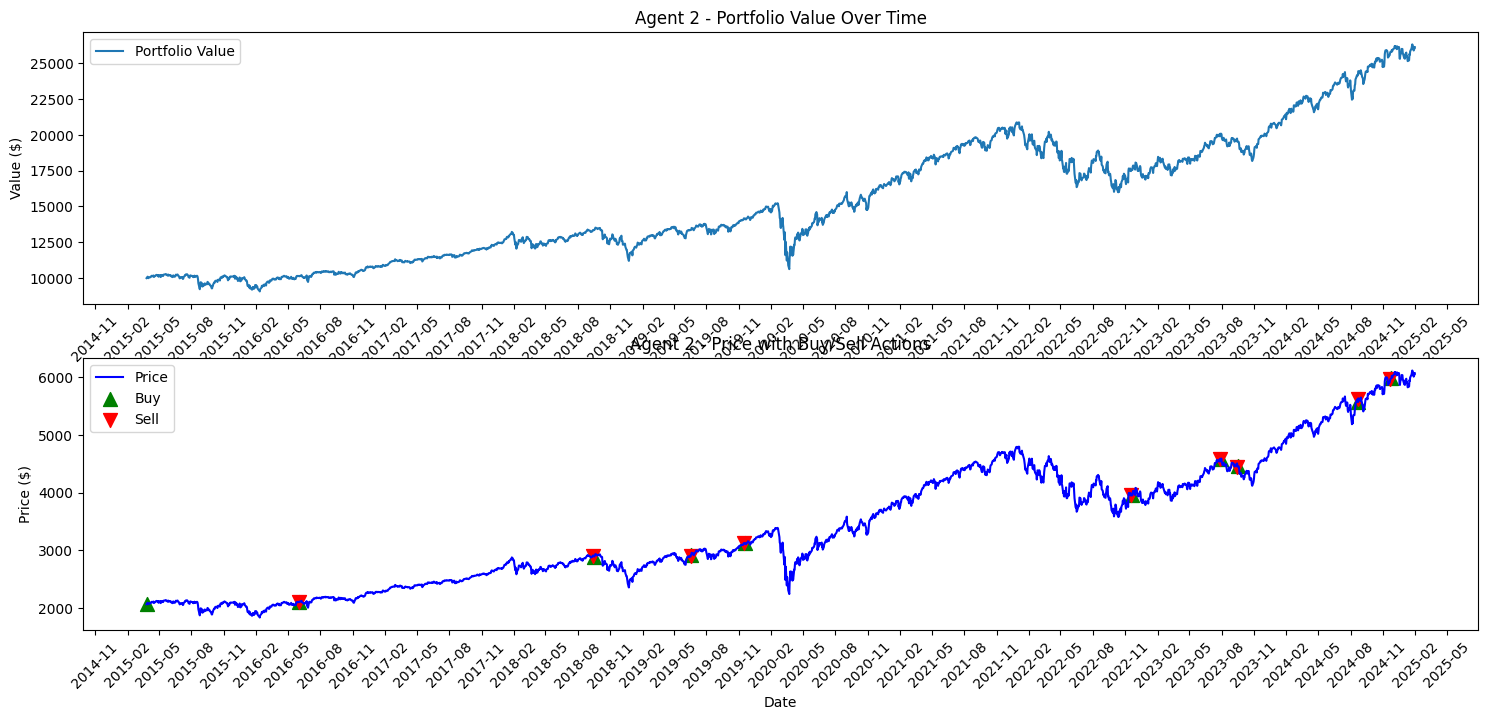

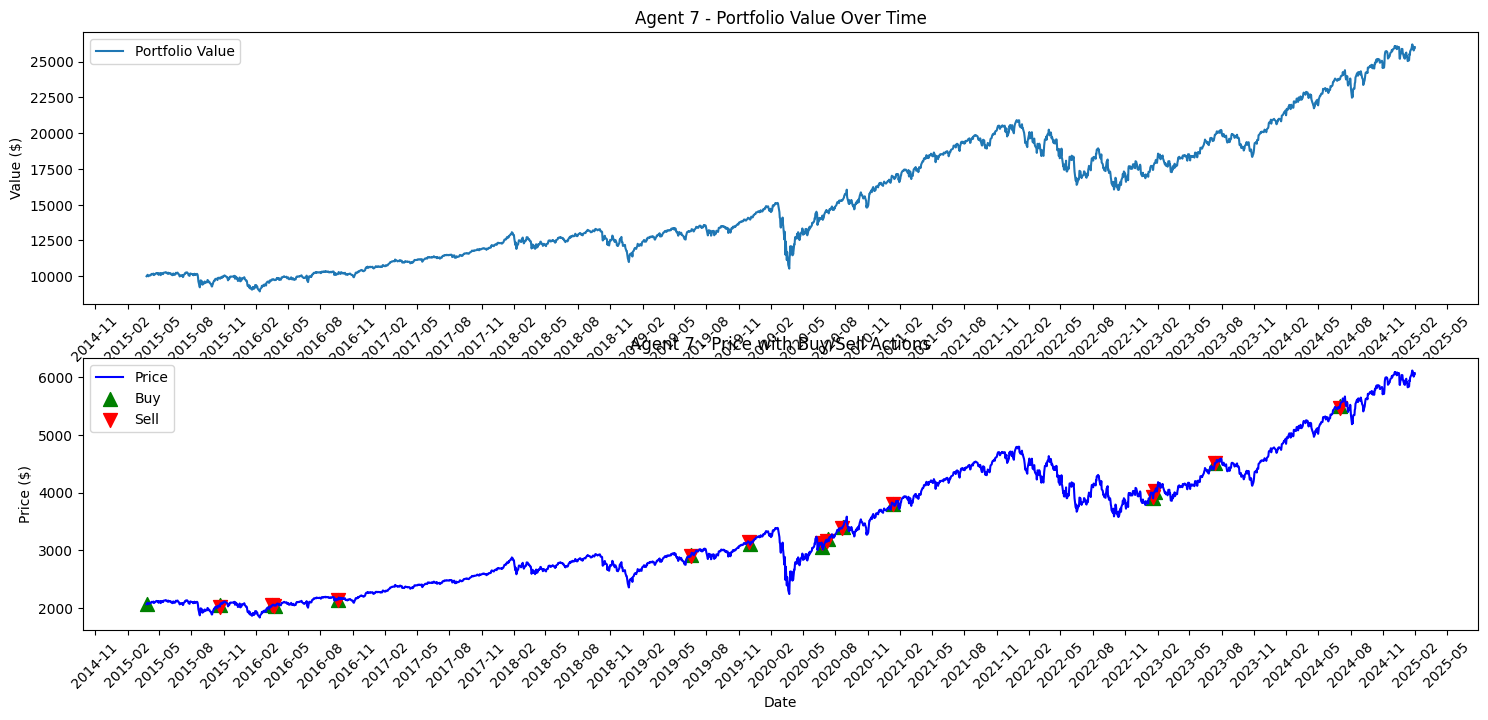

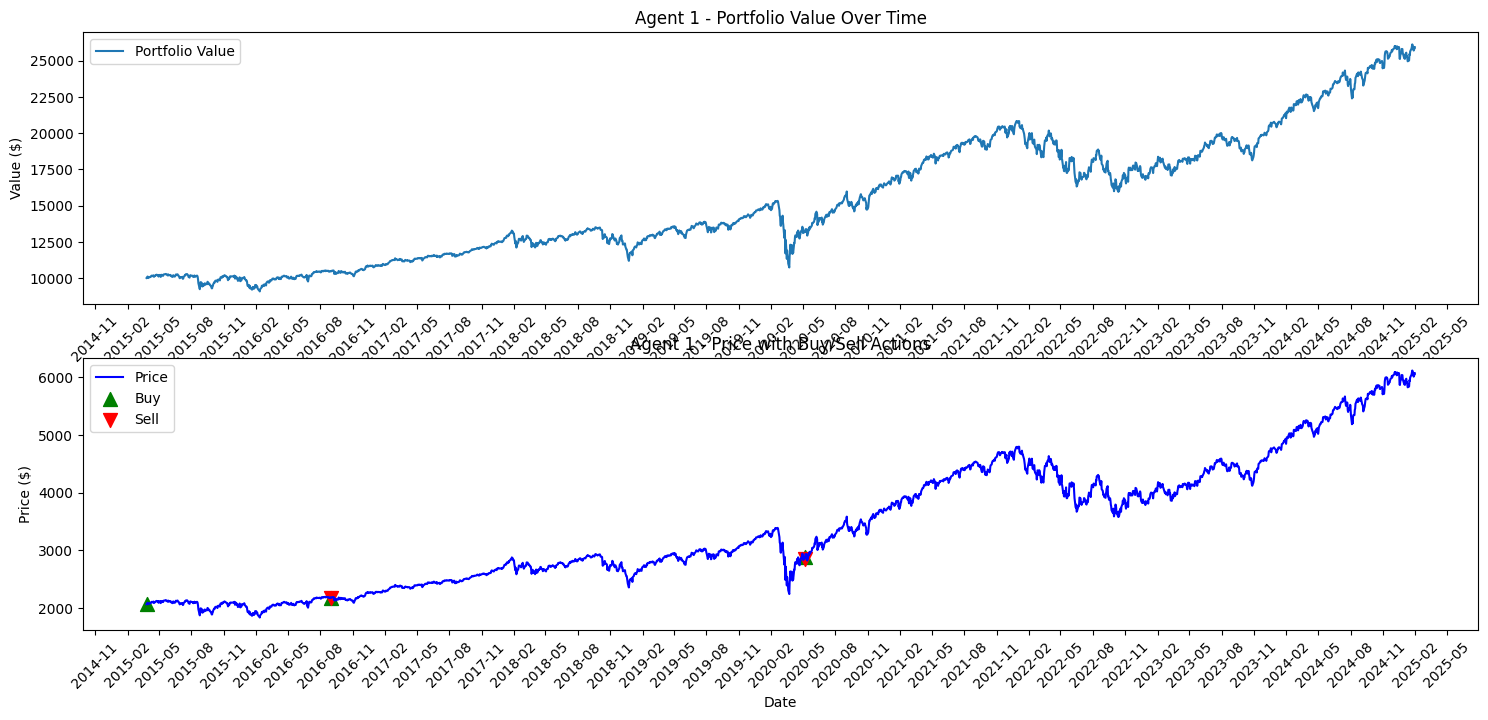

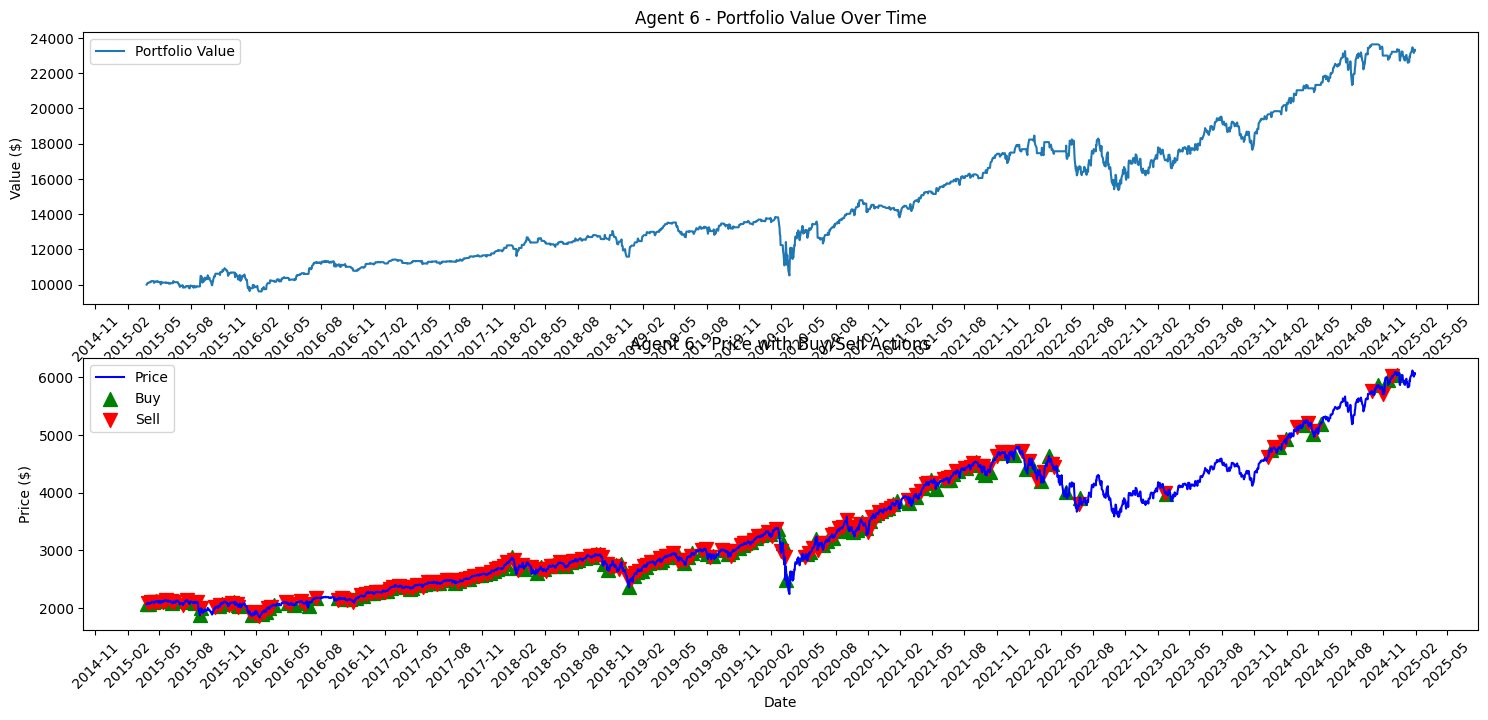

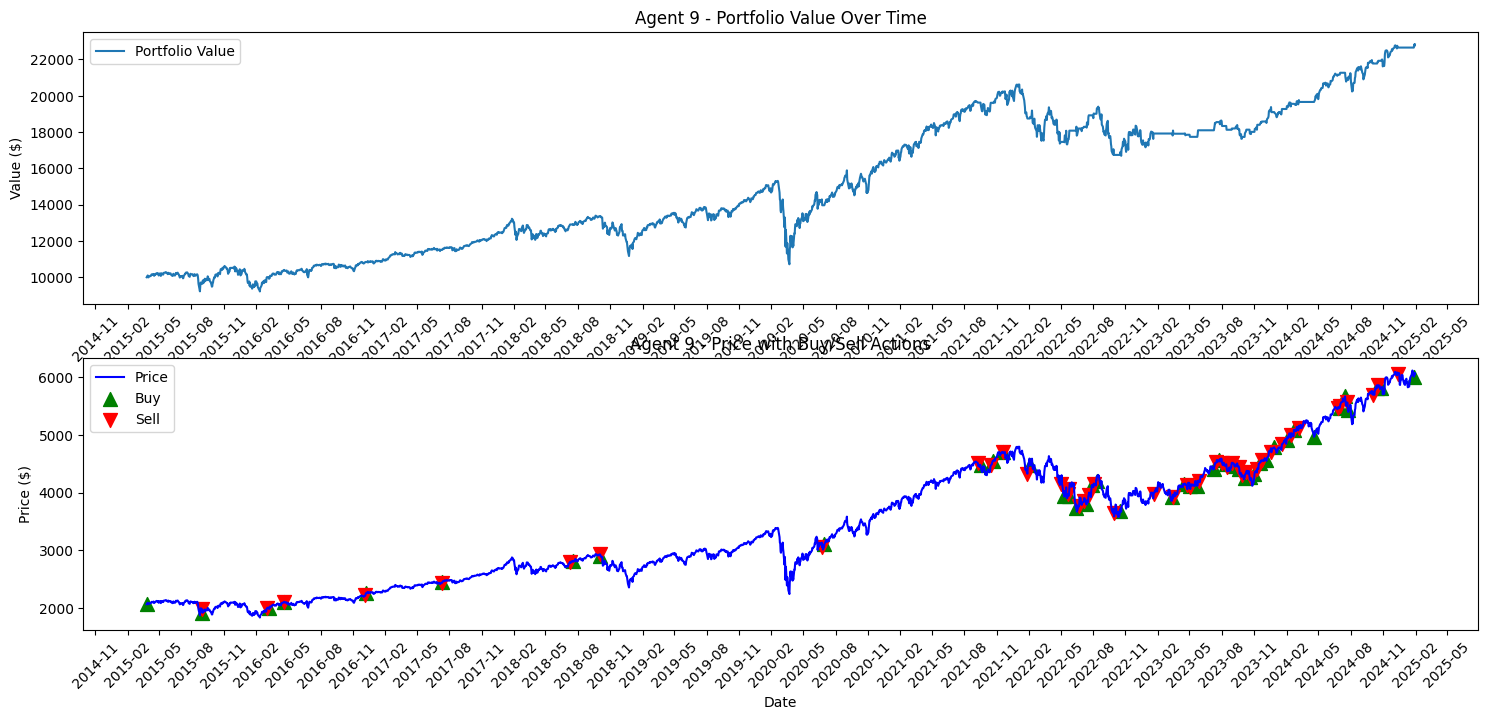

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For better date formatting

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.action_dim))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([i[0] for i in minibatch])
        actions = torch.LongTensor([i[1] for i in minibatch])
        rewards = torch.FloatTensor([i[2] for i in minibatch])
        next_states = torch.FloatTensor([i[3] for i in minibatch])
        dones = torch.FloatTensor([i[4] for i in minibatch])

        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        next_q = self.model(next_states).detach().max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class FinancialTradingEnv(gym.Env):
    def __init__(self, data):
        super(FinancialTradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_steps = len(data) - 1
        self.action_space = spaces.Discrete(3)  # 0: Sell, 1: Hold, 2: Buy
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)

        # Track portfolio value and actions for visualization
        self.portfolio_values = [self.initial_balance]
        self.actions_taken = []
        self.prices = []
        self.dates = [data.iloc[0]['Date']]  # Initialize with the first date

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.current_step = 0
        self.portfolio_values = [self.initial_balance]
        self.actions_taken = []
        self.prices = []
        self.dates = [self.data.iloc[0]['Date']]  # Reset with the first date
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            self.data.iloc[self.current_step]['Close'],
            self.data.iloc[self.current_step]['Volume'],
            self.data.iloc[self.current_step]['MA5'],
            self.data.iloc[self.current_step]['MA10'],
            self.data.iloc[self.current_step]['RSI'],
            self.balance / self.initial_balance
        ])
        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        current_date = self.data.iloc[self.current_step]['Date']
        self.current_step += 1

        # Enforce spot position rules
        if action == 0:  # Sell
            if self.shares_held > 0:  # Can only sell if shares are held
                self.balance += self.shares_held * current_price
                self.shares_held = 0
            else:
                action = 1  # If no shares, force hold
        elif action == 2:  # Buy
            if self.shares_held == 0:  # Can only buy if no shares are held
                shares_bought = self.balance // current_price
                self.balance -= shares_bought * current_price
                self.shares_held += shares_bought
            else:
                action = 1  # If shares are already held, force hold

        self.net_worth = self.balance + self.shares_held * current_price
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0 or self.current_step >= self.max_steps

        # Record portfolio value, actions, prices, and dates
        self.portfolio_values.append(self.net_worth)
        self.actions_taken.append(action)
        self.prices.append(current_price)
        self.dates.append(current_date)

        return self._next_observation(), reward, done, {}

    def get_metrics(self):
        """Calculate performance metrics for the episode."""
        returns = np.diff(self.portfolio_values) / np.array(self.portfolio_values[:-1])
        total_return = (self.net_worth - self.initial_balance) / self.initial_balance
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
        max_drawdown = (np.max(self.portfolio_values) - np.min(self.portfolio_values)) / np.max(self.portfolio_values)

        return {
            "Total Return (%)": total_return * 100,
            "Sharpe Ratio": sharpe_ratio,
            "Max Drawdown (%)": max_drawdown * 100,
            "Final Portfolio Value": self.net_worth,
        }

def train_agent(agent_class, env_class, data, episodes=10):
    """Train a single agent and return its performance data."""
    env = env_class(data)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = agent_class(state_dim, action_dim)
    episode_rewards = []
    episode_metrics = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward

        # Record episode metrics
        episode_rewards.append(total_reward)
        metrics = env.get_metrics()
        episode_metrics.append(metrics)

    return agent, env.portfolio_values, env.actions_taken, env.prices, env.dates, episode_metrics

def plot_agent_performance(agent_id, portfolio_values, actions_taken, prices, dates):
    """Plot performance for a single agent."""
    plt.figure(figsize=(18, 12))

    # Convert dates to datetime objects for better formatting
    dates = pd.to_datetime(dates)

    # Plot portfolio value
    plt.subplot(3, 1, 1)
    plt.plot(dates, portfolio_values, label="Portfolio Value")
    plt.title(f"Agent {agent_id} - Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as YYYY-MM
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show dates every 3 months
    plt.xticks(rotation=45)
    plt.legend()

    # Plot price with buy/sell actions
    plt.subplot(3, 1, 2)
    plt.plot(dates[1:], prices, label="Price", color="blue")  # Skip the first date (initial state)
    buy_indices = [i for i, action in enumerate(actions_taken) if action == 2]
    sell_indices = [i for i, action in enumerate(actions_taken) if action == 0]
    plt.scatter([dates[i + 1] for i in buy_indices], [prices[i] for i in buy_indices], color="green", marker="^", label="Buy", s=100)
    plt.scatter([dates[i + 1] for i in sell_indices], [prices[i] for i in sell_indices], color="red", marker="v", label="Sell", s=100)
    plt.title(f"Agent {agent_id} - Price with Buy/Sell Actions")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as YYYY-MM
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show dates every 3 months
    plt.xticks(rotation=45)
    plt.legend()

def main():
    df = pd.read_csv('final_df.csv')
    numeric_columns = ['Close', 'Volume', 'MA5', 'MA10', 'RSI']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Train multiple agents
    num_agents = 10  # Number of agents to train
    agents_data = []
    for i in range(num_agents):
        print(f"Training Agent {i + 1}...")
        agent, portfolio_values, actions_taken, prices, dates, metrics = train_agent(DQNAgent, FinancialTradingEnv, df)
        agents_data.append({
            "agent_id": i + 1,
            "portfolio_values": portfolio_values,
            "actions_taken": actions_taken,
            "prices": prices,
            "dates": dates,
            "metrics": metrics[-1],  # Metrics for the last episode
            "final_portfolio_value": portfolio_values[-1]  # Final portfolio value for ranking
        })
        print(f"Agent {i + 1} Metrics:", agents_data[-1]["metrics"])

    # Rank agents by final portfolio value and select top 5
    agents_data.sort(key=lambda x: x["final_portfolio_value"], reverse=True)
    top_5_agents = agents_data[:5]

    # Plot performance for the top 5 agents
    for agent in top_5_agents:
        plot_agent_performance(
            agent["agent_id"],
            agent["portfolio_values"],
            agent["actions_taken"],
            agent["prices"],
            agent["dates"]
        )

if __name__ == '__main__':
    main()